In [1]:
from Quantum_Games import player, entanglement_layer, game_circuit, get_aer_result
from qiskit.circuit.library import efficient_su2, real_amplitudes
import pandas as pd

from qiskit import QuantumCircuit
import numpy as np

In [2]:
params = [(np.random.uniform(0, 4 * np.pi), np.random.uniform(0, 4 * np.pi)) for _ in range(10)]
strategies = [efficient_su2(1, reps=0).assign_parameters(parameters=param) for param in params]
probabilities = [1/len(strategies) for _ in range(len(strategies))]

alice = player(name='alice',
                strategies=strategies,
                probabilities=probabilities)

In [3]:
params = [(np.random.uniform(0, 4 * np.pi), np.random.uniform(0, 4 * np.pi)) for _ in range(10)]
strategies = [efficient_su2(1, reps=0).assign_parameters(parameters=param) for param in params]
probabilities = [1/len(strategies) for _ in range(len(strategies))]

bob = player(name='bob',
                strategies=strategies,
                probabilities=probabilities)

In [4]:
params = [(np.random.uniform(0, 4 * np.pi), np.random.uniform(0, 4 * np.pi)) for _ in range(10)]
strategies = [efficient_su2(1, reps=0).assign_parameters(parameters=param) for param in params]
probabilities = [1/len(strategies) for _ in range(len(strategies))]

jack = player(name='jack',
                strategies=strategies,
                probabilities=probabilities)

In [5]:
referee = real_amplitudes(2, reps=1)
referee.assign_parameters(4*np.pi*np.random.rand(referee.num_parameters), inplace=True)
referee = referee.to_gate(label='ref')

In [19]:
circuit = game_circuit(players=[alice, bob, jack],
                       #referee_ansatz=referee,
                       #players=[alice, bob, jack],
                       insert_barriers=True)

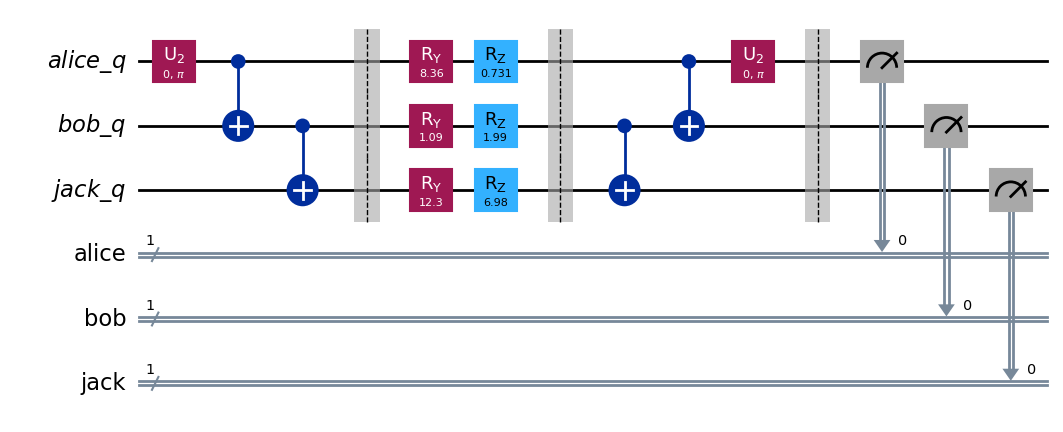

In [20]:
circuit.decompose(reps=1).draw('mpl')

In [21]:
result = get_aer_result(circuit)

In [10]:
def calculate_payout(results):
    outcomes = {'(0, 0)' : (3,3), '(0, 1)' : (0,6),
                '(1, 0)' : (6,0),'(1, 1)' : (1,1)}
    player_results = {player : [] for player in result.keys()}
    player_1 = 'alice'
    player_2 = 'bob'

    for p1, p2  in zip(results[player_1], results[player_2]):
        p1_outcome, p2_outcome = outcomes[str((p1,p2))]
        player_results[player_1].append(p1_outcome)
        player_results[player_2].append(p2_outcome)

    return player_results

In [11]:
player_results = calculate_payout(result)

print('Alice average result: ', np.mean(player_results['alice']))
print('Bob average result: ', np.mean(player_results['bob']))

Alice average result:  4.607
Bob average result:  1.373
